## Load datasets

In [45]:
"""BERT model for Question Answering (span extraction).
    This module is composed of the BERT model with a linear layer on top of
    the sequence output that computes start_logits and end_logits

    Params:
        `config`: a BertConfig class instance with the configuration to build a new model.

    Inputs:
        `input_ids`: a torch.LongTensor of shape [batch_size, sequence_length]
            with the word token indices in the vocabulary(see the tokens preprocessing logic in the scripts
            `extract_features.py`, `run_classifier.py` and `run_squad.py`)
        `token_type_ids`: an optional torch.LongTensor of shape [batch_size, sequence_length] with the token
            types indices selected in [0, 1]. Type 0 corresponds to a `sentence A` and type 1 corresponds to
            a `sentence B` token (see BERT paper for more details).
        `attention_mask`: an optional torch.LongTensor of shape [batch_size, sequence_length] with indices
            selected in [0, 1]. It's a mask to be used if the input sequence length is smaller than the max
            input sequence length in the current batch. It's the mask that we typically use for attention when
            a batch has varying length sentences.
        `start_positions`: position of the first token for the labeled span: torch.LongTensor of shape [batch_size].
            Positions are clamped to the length of the sequence and position outside of the sequence are not taken
            into account for computing the loss.
        `end_positions`: position of the last token for the labeled span: torch.LongTensor of shape [batch_size].
            Positions are clamped to the length of the sequence and position outside of the sequence are not taken
            into account for computing the loss.

    Outputs:
        if `start_positions` and `end_positions` are not `None`:
            Outputs the total_loss which is the sum of the CrossEntropy loss for the start and end token positions.
        if `start_positions` or `end_positions` is `None`:
            Outputs a tuple of start_logits, end_logits which are the logits respectively for the start and end
            position tokens of shape [batch_size, sequence_length].

    Example usage:
    ```python
    # Already been converted into WordPiece token ids
    input_ids = torch.LongTensor([[31, 51, 99], [15, 5, 0]])
    input_mask = torch.LongTensor([[1, 1, 1], [1, 1, 0]])
    token_type_ids = torch.LongTensor([[0, 0, 1], [0, 1, 0]])

    config = BertConfig(vocab_size_or_config_json_file=32000, hidden_size=768,
        num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)

    model = BertForQuestionAnswering(config)
    start_logits, end_logits = model(input_ids, token_type_ids, input_mask)
    ```
"""

"BERT model for Question Answering (span extraction).\n    This module is composed of the BERT model with a linear layer on top of\n    the sequence output that computes start_logits and end_logits\n\n    Params:\n        `config`: a BertConfig class instance with the configuration to build a new model.\n\n    Inputs:\n        `input_ids`: a torch.LongTensor of shape [batch_size, sequence_length]\n            with the word token indices in the vocabulary(see the tokens preprocessing logic in the scripts\n            `extract_features.py`, `run_classifier.py` and `run_squad.py`)\n        `token_type_ids`: an optional torch.LongTensor of shape [batch_size, sequence_length] with the token\n            types indices selected in [0, 1]. Type 0 corresponds to a `sentence A` and type 1 corresponds to\n            a `sentence B` token (see BERT paper for more details).\n        `attention_mask`: an optional torch.LongTensor of shape [batch_size, sequence_length] with indices\n            selec

In [17]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import collections
import logging
import json
import math
import os
import random
import pickle
import numpy as np
import torch

from tqdm import tqdm, trange
from bert_utils.bert_utils import *
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler

from pytorch_pretrained_bert.tokenization import whitespace_tokenize, BasicTokenizer, BertTokenizer
from pytorch_pretrained_bert.modeling import BertForQuestionAnswering
from pytorch_pretrained_bert.optimization import BertAdam
from pytorch_pretrained_bert.file_utils import PYTORCH_PRETRAINED_BERT_CACHE

Configuration settings

In [18]:
config = {'language':'kor', 'model_config':123}

## logger settings
logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

if 'eng' in config['language']:
    train_file = './datasets/squad_v1.1/train-v1.1.json'
    dev_file = './datasets/squad_v1.1/dev-v1.1.json'
elif 'kor' in config['language']:
    train_file = './datasets/korquad_v1/KorQuAD_v1.0_train.json'
    dev_file = './datasets/korquad_v1/KorQuAD_v1.0_dev.json'    

In [19]:
def read_json(file_name):
    print("reading {}".format(file_name))
    with open(file_name, "r", encoding='utf-8') as reader:
        # >> type(input_data) -> list
        input_data = json.load(reader)["data"]
    print("success to read {}".format(file_name))
    return input_data

In [20]:
input_data = read_json(train_file)

reading ./datasets/korquad_v1/KorQuAD_v1.0_train.json
success to read ./datasets/korquad_v1/KorQuAD_v1.0_train.json


explore the datasets

In [21]:
type(input_data), type(input_data[0]), input_data[0].keys(), type(input_data[0]['paragraphs'])

(list, dict, dict_keys(['paragraphs', 'title']), list)

In [22]:
input_data[0]['paragraphs'][1]

{'qas': [{'answers': [{'text': '한스 폰 뷜로', 'answer_start': 402}],
   'id': '6566495-1-0',
   'question': '바그너의 작품을 시인의 피로 쓰여졌다고 극찬한 것은 누구인가?'},
  {'answers': [{'text': '리스트', 'answer_start': 23}],
   'id': '6566495-1-1',
   'question': '잊혀져 있는 파우스트 서곡 1악장을 부활시킨 것은 누구인가?'},
  {'answers': [{'text': '20루이의 금', 'answer_start': 345}],
   'id': '6566495-1-2',
   'question': '바그너는 다시 개정된 총보를 얼마를 받고 팔았는가?'},
  {'answers': [{'text': '리스트', 'answer_start': 23}],
   'id': '6566518-1-0',
   'question': '파우스트 교향곡을 부활시킨 사람은?'},
  {'answers': [{'text': '한스 폰 뷜로', 'answer_start': 402}],
   'id': '6566518-1-1',
   'question': '파우스트 교향곡을 피아노 독주용으로 편곡한 사람은?'},
  {'answers': [{'text': '리스트', 'answer_start': 23}],
   'id': '5917067-1-0',
   'question': '1악장을 부활시켜 연주한 사람은?'},
  {'answers': [{'text': '한스 폰 뷜로', 'answer_start': 402}],
   'id': '5917067-1-1',
   'question': '파우스트 교향곡에 감탄하여 피아노곡으로 편곡한 사람은?'},
  {'answers': [{'text': '1840년', 'answer_start': 3}],
   'id': '5917067-1-2',
   'question': '리스트가 바그너와 

## parse datasets

In [23]:
class SquadExample(object):
    """A single training/test example for the Squad dataset."""

    def __init__(self,
                 qas_id,
                 question_text,
                 doc_tokens,
                 orig_answer_text=None,
                 start_position=None,
                 end_position=None):
        self.qas_id = qas_id
        self.question_text = question_text
        self.doc_tokens = doc_tokens
        self.orig_answer_text = orig_answer_text
        self.start_position = start_position
        self.end_position = end_position

    def __str__(self):
        return self.__repr__()

    def __repr__(self):
        s = ""
        s += "qas_id: %s" % (self.qas_id)
        s += "\n\n, question_text: %s" % (
            self.question_text)
        s += "\n\n, orig_answer_text: %s" % (
            self.orig_answer_text)
        s += "\n\n, doc_tokens: [%s]" % (" ".join(self.doc_tokens))
        if self.start_position:
            s += "\n\n, start_position: %d" % (self.start_position)
        if self.start_position:
            s += "\n\n, end_position: %d" % (self.end_position)
        return s

In [24]:
#실습 자료

In [25]:
def is_whitespace(c):
    if c == " " or c == "\t" or c == "\r" or c == "\n" or ord(c) == 0x202F:
        return True
    return False

def parse_json_squad(input_data, is_train):
    """Read a SQuAD json file into a list of SquadExample."""
    examples = list()
    for data_entry in input_data:
        for paragraph in data_entry['paragraphs']:
            paragraph_text = paragraph["context"]
            doc_tokens = []
            char_to_word_offset = []
            prev_is_whitespace = True

            # Q1. doc_tokens에 whitespace(c)를 가지고 context를 토큰화하는 코드를 작성하세요.
            ###################################################################################################
            for char in paragraph_text:
                if is_whitespace(char):
                    prev_is_whitespace = True
                else:
                    if prev_is_whitespace:
                        doc_tokens.append(char)
                    else:
                        doc_tokens[-1] += char
                    prev_is_whitespace = False
                char_to_word_offset.append(len(doc_tokens) - 1)  # Which word is the character in?
            ###################################################################################################
    
            for qa in paragraph["qas"]:
                """
                {'answers': [{'answer_start', 'text'}], 'question', 'id'}
                """
                qas_id = qa["id"]
                question_text = qa["question"]
                start_position = None
                end_position = None
                orig_answer_text = None

                if is_train:
                    if len(qa["answers"]) != 1:
                        raise ValueError(
                            "For training, each question should have exactly 1 answer.")
                    
                    # Q2. Line 34의 변수를 참고하여 Line 70: SquadExample의 instance를 만들기 위한 파라미터를 채우세요.  
                    ###################################################################################################
                    qas_id = qa["id"]     # fill the black -> assign None
                    question_text = qa["question"] # fill the black # index of word
                    answer = qa["answers"][0]
                    orig_answer_text = answer["text"]
                    answer_offset = answer["answer_start"]
                    answer_length = len(orig_answer_text)
                    start_position = char_to_word_offset[answer_offset] # index of word
                    end_position = char_to_word_offset[answer_offset + answer_length - 1] # index of word
                    ###################################################################################################

                    # CODE FOR Handling exceptions 
                    # Only add answers where the text can be exactly recovered from the
                    # document. If this CAN'T happen it's likely due to weird Unicode
                    # stuff so we will just skip the example.
                    #
                    # Note that this means for training mode, every example is NOT
                    # guaranteed to be preserved.
                    actual_text = " ".join(doc_tokens[start_position:(end_position + 1)])
                    cleaned_answer_text = " ".join(whitespace_tokenize(
                        orig_answer_text))  # segment words from the sentense including the white space
                    if actual_text.find(cleaned_answer_text) == -1:
                        logger.warning("Could not find answer: '%s' vs. '%s'",
                                       actual_text, cleaned_answer_text)
                        continue

                example = SquadExample(
                    qas_id=qas_id,
                    question_text=question_text,
                    doc_tokens=doc_tokens,  # a set of tokens(words) in the
                    orig_answer_text=orig_answer_text,
                    start_position=start_position,
                    end_position=end_position)
                examples.append(example)
    print("success to convert input data into a set of {} examples".format(len(examples)))
    return examples

In [26]:
train_examples = parse_json_squad(input_data, True)
## len of examples 87599

success to convert input data into a set of 60407 examples


In [27]:
print(train_examples[0])

qas_id: 6566495-0-0

, question_text: 바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?

, orig_answer_text: 교향곡

, doc_tokens: [1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.]

, start_position: 14

, end_position: 14


## Extract Feature

In [31]:
class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self,
                 unique_id,
                 example_index,
                 doc_span_index,
                 tokens,
                 token_to_orig_map,
                 token_is_max_context,
                 input_ids,
                 input_mask,
                 segment_ids,
                 start_position=None,
                 end_position=None):
        
        self.unique_id = unique_id
        self.example_index = example_index
        self.doc_span_index = doc_span_index
        self.tokens = tokens
        self.token_to_orig_map = token_to_orig_map
        self.token_is_max_context = token_is_max_context
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.start_position = start_position
        self.end_position = end_position

In [35]:
def convert_examples_to_features(examples, tokenizer, max_seq_length,
                                 doc_stride, max_query_length, is_training):
    """Loads a data file into a list of `InputBatch`s."""

    unique_id = 1000000000

    features = []
    
    for (example_index, example) in enumerate(examples):
        
        # Q3. Pretrained model을 학습하는데 사용한 Tokenizer를 사용하여 question과 context의 token을 sub-token으로 토큰화해주세요.  
        ###################################################################################################
        query_tokens = tokenizer.tokenize(example.question_text)
        if len(query_tokens) > max_query_length:
            query_tokens = query_tokens[0:max_query_length]
            
        tok_to_orig_index = []
        orig_to_tok_index = []
        all_doc_tokens = []     
        for (i, token) in enumerate(example.doc_tokens):
            orig_to_tok_index.append(len(all_doc_tokens))
            sub_tokens = tokenizer.tokenize(token)
            for sub_token in sub_tokens: 
                tok_to_orig_index.append(i)                  
                all_doc_tokens.append(sub_token)
        ###################################################################################################

                
        # Q4. sub-tokens에 맞추어 span을 업데이트 해주세요.
        ###################################################################################################
        tok_start_position = None
        tok_end_position = None
        if is_training:
            tok_start_position = orig_to_tok_index[example.start_position]
            if example.end_position < len(example.doc_tokens) - 1:
                tok_end_position = orig_to_tok_index[example.end_position + 1] - 1
            else:
                tok_end_position = len(all_doc_tokens) - 1
            (tok_start_position, tok_end_position) = improve_answer_span(
                all_doc_tokens, tok_start_position, tok_end_position, tokenizer,
                example.orig_answer_text)
        ####################################################################################################
        
        # The -3 accounts for [CLS], [SEP] and [SEP]
        max_tokens_for_doc = max_seq_length - len(query_tokens) - 3

        # doc_tokens가 설정한 max length를 넘는다면, 몇개의 DocSpan으로 쪼개야 합니다.
        # We can have documents that are longer than the maximum sequence length.
        # To deal with this we do a sliding window approach, where we take chunks
        # of the up to our max length with a stride of `doc_stride`.
        _DocSpan = collections.namedtuple(  # pylint: disable=invalid-name
            "DocSpan", ["start", "length"])
        doc_spans = []
        start_offset = 0
        while start_offset < len(all_doc_tokens):
            length = len(all_doc_tokens) - start_offset # 남은 길이
            if length > max_tokens_for_doc:
                length = max_tokens_for_doc
            doc_spans.append(_DocSpan(start=start_offset, length=length))
            if start_offset + length == len(all_doc_tokens):
                break
            start_offset += min(length, doc_stride)
            
            
        for (doc_span_index, doc_span) in enumerate(doc_spans):
            tokens = [] # input data
            segment_ids = [] # segment data
            token_to_orig_map = {}
            token_is_max_context = {}

            # Q5. query를 pretrained BERT의 입력값(features) 형식에 따라 바꿔주세요.
              # tokens -> [CLS] question [SEP] context [SEP]
              # segment_ids -> 00000000000000000000 1111111111111
            ###################################################################################################            
            tokens.append("[CLS]")
            segment_ids.append(0)
            for token in query_tokens:
                tokens.append(token)
                segment_ids.append(0)
            tokens.append("[SEP]")
            segment_ids.append(0)
            ###################################################################################################

                
            # Q6. context를 pretrained BERT의 입력값(features) 형식에 따라 바꿔주세요.
            ###################################################################################################
            for i in range(doc_span.length):
                split_token_index = doc_span.start + i
                token_to_orig_map[len(tokens)] = tok_to_orig_index[split_token_index]
                is_max_context = check_is_max_context(doc_spans,doc_span_index,split_token_index)
                token_is_max_context[len(tokens)] = is_max_context
                tokens.append(all_doc_tokens[split_token_index])
                segment_ids.append(1) # segment ids 12 means the context
            tokens.append("[SEP]")
            segment_ids.append(1)
            ###################################################################################################
            
            # convert into the index of emmeding matrix
            input_ids = tokenizer.convert_tokens_to_ids(tokens)

            # Q7. pretrained BERT의 입력값 크기에 맞게 zero-padding 해주세요.
            ###################################################################################################
            # The mask has 1 for real tokens and 0 for padding tokens. Only real
            # tokens are attended to.
            input_mask = [1] * len(input_ids)
            while len(input_ids) < max_seq_length:
                input_ids.append(0)
                input_mask.append(0)
                segment_ids.append(0)

            assert len(input_ids) == max_seq_length
            assert len(input_mask) == max_seq_length
            assert len(segment_ids) == max_seq_length
            ###################################################################################################
            
            start_position = None
            end_position = None
            if is_training:
                # For training, if our document chunk does not contain an annotation
                # we throw it out, since there is nothing to predict.
                doc_start = doc_span.start
                doc_end = doc_span.start + doc_span.length - 1
                if (example.start_position < doc_start or
                        example.end_position < doc_start or
                        example.start_position > doc_end or example.end_position > doc_end):
                    continue # -> next to the DocSpan 

                doc_offset = len(query_tokens) + 2
                start_position = tok_start_position - doc_start + doc_offset
                end_position = tok_end_position - doc_start + doc_offset

            if example_index < 20:
                logger.info("*** Example ***")
                logger.info("unique_id: %s" % (unique_id))
                logger.info("example_index: %s" % (example_index))
                logger.info("doc_span_index: %s" % (doc_span_index))
                logger.info("tokens: %s" % " ".join(tokens))
                logger.info("token_to_orig_map: %s" % " ".join([
                    "%d:%d" % (x, y) for (x, y) in token_to_orig_map.items()]))
                logger.info("token_is_max_context: %s" % " ".join([
                    "%d:%s" % (x, y) for (x, y) in token_is_max_context.items()
                ]))
                logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
                logger.info(
                    "input_mask: %s" % " ".join([str(x) for x in input_mask]))
                logger.info(
                    "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
                if is_training:
                    answer_text = " ".join(tokens[start_position:(end_position + 1)])
                    logger.info("start_position: %d" % (start_position))
                    logger.info("end_position: %d" % (end_position))
                    logger.info(
                        "answer: %s" % (answer_text))
                    
            features.append(
                InputFeatures(
                    unique_id=unique_id,
                    example_index=example_index,
                    doc_span_index=doc_span_index,
                    tokens=tokens,
                    token_to_orig_map=token_to_orig_map,
                    token_is_max_context=token_is_max_context,
                    input_ids=input_ids,
                    input_mask=input_mask,
                    segment_ids=segment_ids,
                    start_position=start_position,
                    end_position=end_position))
            unique_id += 1

    return features

## Wrap the train_features in a `Dataloader`

In [36]:
config='bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(config)
max_seq_length=128
doc_stride=128
max_query_length=64
cached_train_features_file = train_file+'_{0}_{1}_{2}'.format(config, str(max_seq_length), str(doc_stride))

train_batch_size=15
predict_batch_size=15
num_train_epochs=2
gradient_accumulation_steps=1
warmup_proportion=0.1
learning_rate=5e-5
num_train_steps = int(num_train_epochs * len(train_examples) / train_batch_size) #  /gradient_accumulation_steps *num_train_epochs

08/11/2020 03:27:18 - WARNING - pytorch_pretrained_bert.tokenization -   The pre-trained model you are loading is a cased model but you have not set `do_lower_case` to False. We are setting `do_lower_case=False` for you but you may want to check this behavior.
08/11/2020 03:27:19 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-vocab.txt from cache at /home/daehoon/.pytorch_pretrained_bert/96435fa287fbf7e469185f1062386e05a075cadbf6838b74da22bf64b080bc32.99bcd55fc66f4f3360bc49ba472b940b8dcf223ea6a345deb969d607ca900729


In [38]:
try:
    with open(cached_train_features_file, "rb") as reader:
        train_features = pickle.load(reader)
except:
    train_features = convert_examples_to_features(
        examples=train_examples,
        tokenizer=tokenizer,
        max_seq_length=max_seq_length,
        doc_stride=doc_stride,
        max_query_length=max_query_length,
        is_training=True)
    print('finish extracting the features from the examples')
    logger.info("  Saving train features into cached file %s", cached_train_features_file)
    with open(cached_train_features_file, "wb") as writer:
        pickle.dump(train_features, writer)

08/11/2020 03:28:09 - INFO - __main__ -   *** Example ***
08/11/2020 03:28:09 - INFO - __main__ -   unique_id: 1000000000
08/11/2020 03:28:09 - INFO - __main__ -   example_index: 0
08/11/2020 03:28:09 - INFO - __main__ -   doc_span_index: 0
08/11/2020 03:28:09 - INFO - __main__ -   tokens: [CLS] 바 ##그 ##너 ##는 괴 ##테 ##의 파 ##우스 ##트를 읽 ##고 무 ##엇 ##을 쓰 ##고 ##자 했 ##는 ##가 ? [SEP] 1839 ##년 바 ##그 ##너 ##는 괴 ##테 ##의 파 ##우스 ##트 ##을 처음 읽 ##고 그 내 ##용 ##에 마 ##음 ##이 끌 ##려 이를 소 ##재 ##로 해 ##서 하나의 교 ##향 ##곡 ##을 쓰 ##려 ##는 뜻 ##을 갖 ##는다 . 이 시 ##기 바 ##그 ##너 ##는 1838 ##년에 빛 독 ##촉 ##으로 산 ##전 ##수 ##전을 다 [UNK] 상 ##황 ##이 ##라 좌 ##절 ##과 실 ##망 ##에 가 ##득 ##했으며 메 ##피 ##스 ##토 ##펠 ##레스 ##를 만 ##나는 파 ##우스 ##트 ##의 심 ##경 ##에 공 ##감 ##했다 ##고 한다 . 또한 파 ##리에 ##서 아 [SEP]
08/11/2020 03:28:09 - INFO - __main__ -   token_to_orig_map: 24:0 25:0 26:1 27:1 28:1 29:1 30:2 31:2 32:2 33:3 34:3 35:3 36:3 37:4 38:5 39:5 40:6 41:7 42:7 43:7 44:8 45:8 46:8 47:9 48:9 49:10 50:11 51:11 52:11 53:12 54:12 55:13 56:14 57:14 58:14 59:14 60:15 61:

08/11/2020 03:28:09 - INFO - __main__ -   token_to_orig_map: 23:0 24:0 25:1 26:1 27:1 28:1 29:2 30:2 31:2 32:3 33:3 34:3 35:3 36:4 37:5 38:5 39:6 40:7 41:7 42:7 43:8 44:8 45:8 46:9 47:9 48:10 49:11 50:11 51:11 52:12 53:12 54:13 55:14 56:14 57:14 58:14 59:15 60:15 61:15 62:16 63:16 64:17 65:17 66:17 67:18 68:19 69:19 70:20 71:20 72:20 73:20 74:21 75:21 76:22 77:23 78:23 79:23 80:24 81:24 82:24 83:24 84:25 85:26 86:27 87:27 88:27 89:27 90:28 91:28 92:28 93:29 94:29 95:29 96:30 97:30 98:30 99:31 100:31 101:31 102:31 103:31 104:31 105:31 106:32 107:32 108:33 109:33 110:33 111:33 112:34 113:34 114:34 115:35 116:35 117:35 118:35 119:36 120:36 121:37 122:38 123:38 124:38 125:39 126:39
08/11/2020 03:28:09 - INFO - __main__ -   token_is_max_context: 23:True 24:True 25:True 26:True 27:True 28:True 29:True 30:True 31:True 32:True 33:True 34:True 35:True 36:True 37:True 38:True 39:True 40:True 41:True 42:True 43:True 44:True 45:True 46:True 47:True 48:True 49:True 50:True 51:True 52:True 53:True 5

08/11/2020 03:28:09 - INFO - __main__ -   token_is_max_context: 22:True 23:True 24:True 25:True 26:True 27:True 28:True 29:True 30:True 31:True 32:True 33:True 34:True 35:True 36:True 37:True 38:True 39:True 40:True 41:True 42:True 43:True 44:True 45:True 46:True 47:True 48:True 49:True 50:True 51:True 52:True 53:True 54:True 55:True 56:True 57:True 58:True 59:True 60:True 61:True 62:True 63:True 64:True 65:True 66:True 67:True 68:True 69:True 70:True 71:True 72:True 73:True 74:True 75:True 76:True 77:True 78:True 79:True 80:True 81:True 82:True 83:True 84:True 85:True 86:True 87:True 88:True 89:True 90:True 91:True 92:True 93:True 94:True 95:True 96:True 97:True 98:True 99:True 100:True 101:True 102:True 103:True 104:True 105:True 106:True 107:True 108:True 109:True 110:True 111:True 112:True 113:True 114:True 115:True 116:True 117:True 118:True 119:True 120:True 121:True 122:True 123:True 124:True 125:True 126:True
08/11/2020 03:28:09 - INFO - __main__ -   input_ids: 101 9901 89108 1

08/11/2020 03:28:09 - INFO - __main__ -   input_ids: 101 9318 78136 70162 11287 62849 8907 79544 55670 76512 10622 9954 9657 22333 11018 136 102 16221 10954 9318 78136 70162 11018 8905 119351 10459 9901 89108 15184 10622 62849 9642 11664 8924 8996 24974 10530 9246 32158 10739 8973 26737 35756 9448 36210 11261 9960 12424 90387 8907 79544 55670 10622 9511 26737 11018 9153 10622 8854 40410 119 9638 9485 12310 9318 78136 70162 11018 16347 27056 9387 9088 119267 11467 9407 16617 15891 54918 9056 100 9414 65649 10739 17342 9686 58931 11882 9489 89292 10530 8843 118813 51491 9272 97146 12605 26444 119394 100929 11513 9248 49742 9901 89108 15184 10459 9491 31720 10530 8896 105197 12490 11664 16139 119 19789 9901 46766 12424 9519 52015 77884 20308 10459 9706 119455 11261 102
08/11/2020 03:28:09 - INFO - __main__ -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

08/11/2020 03:28:09 - INFO - __main__ -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
08/11/2020 03:28:09 - INFO - __main__ -   segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
08/11/2020 03:28:09 - INFO - __main__ -   start_position: 262
08/11/2020 03:28:09 - INFO - __main__ -   end_position: 265
08/11/2020 03:28:09 - INFO - __main__ -   answer: 
08/11/2020 03:28:09 - INFO - __main__ -   *** Example ***
08/11/2020 03:28:09 - INFO - __main__ -   unique_id: 1000000009
08/11/2020 03:28:09 - INFO - __main__ -   example_index: 9
08/11/2020 03:28:09 - INF

08/11/2020 03:28:09 - INFO - __main__ -   start_position: 224
08/11/2020 03:28:09 - INFO - __main__ -   end_position: 227
08/11/2020 03:28:09 - INFO - __main__ -   answer: 
08/11/2020 03:28:09 - INFO - __main__ -   *** Example ***
08/11/2020 03:28:09 - INFO - __main__ -   unique_id: 1000000011
08/11/2020 03:28:09 - INFO - __main__ -   example_index: 11
08/11/2020 03:28:09 - INFO - __main__ -   doc_span_index: 0
08/11/2020 03:28:09 - INFO - __main__ -   tokens: [CLS] 파 ##우스 ##트 교 ##향 ##곡 ##을 부 ##활 ##시 ##킨 사 ##람 ##은 ? [SEP] 한편 1840 ##년부터 바 ##그 ##너 ##와 알 ##고 지 ##내 ##던 리 ##스트 ##가 잊 ##혀 ##져 있던 1 ##악 ##장을 부 ##활 ##시 ##켜 1852 ##년에 바 ##이 ##마 ##르 ##에서 연 ##주 ##했다 . 이 ##것을 계 ##기로 바 ##그 ##너 ##도 이 작 ##품 ##에 다시 관 ##심을 갖 ##게 되었고 , 그 해 9월 ##에는 총 ##보 ##의 반 ##환 ##을 요 ##구 ##하여 이를 서 ##곡 ##으로 간 ##추 ##린 다음 수 ##정을 했 ##고 브 ##라 ##이트 ##코 ##프 ##흐 & 헤 ##르 ##텔 출 ##판 ##사에 ##서 출 ##판 ##할 개 ##정 ##판 ##도 준 ##비 ##했다 . 1853 ##년 5월 ##에는 [SEP]
08/11/2020 03:28:09 - INFO - __main__ -   token_to_orig_map: 17:0 18:1 19:1 20:2 2

08/11/2020 03:28:09 - INFO - __main__ -   example_index: 13
08/11/2020 03:28:09 - INFO - __main__ -   doc_span_index: 0
08/11/2020 03:28:09 - INFO - __main__ -   tokens: [CLS] 1 ##악 ##장을 부 ##활 ##시 ##켜 연 ##주 ##한 사 ##람 ##은 ? [SEP] 한편 1840 ##년부터 바 ##그 ##너 ##와 알 ##고 지 ##내 ##던 리 ##스트 ##가 잊 ##혀 ##져 있던 1 ##악 ##장을 부 ##활 ##시 ##켜 1852 ##년에 바 ##이 ##마 ##르 ##에서 연 ##주 ##했다 . 이 ##것을 계 ##기로 바 ##그 ##너 ##도 이 작 ##품 ##에 다시 관 ##심을 갖 ##게 되었고 , 그 해 9월 ##에는 총 ##보 ##의 반 ##환 ##을 요 ##구 ##하여 이를 서 ##곡 ##으로 간 ##추 ##린 다음 수 ##정을 했 ##고 브 ##라 ##이트 ##코 ##프 ##흐 & 헤 ##르 ##텔 출 ##판 ##사에 ##서 출 ##판 ##할 개 ##정 ##판 ##도 준 ##비 ##했다 . 1853 ##년 5월 ##에는 리 [SEP]
08/11/2020 03:28:09 - INFO - __main__ -   token_to_orig_map: 16:0 17:1 18:1 19:2 20:2 21:2 22:2 23:3 24:3 25:4 26:4 27:4 28:5 29:5 30:5 31:6 32:6 33:6 34:7 35:8 36:8 37:8 38:9 39:9 40:9 41:9 42:10 43:10 44:11 45:11 46:11 47:11 48:11 49:12 50:12 51:12 52:12 53:13 54:13 55:14 56:14 57:15 58:15 59:15 60:15 61:16 62:17 63:17 64:17 65:18 66:19 67:19 68:20 69:20 70:21 71:21 72:22 73

08/11/2020 03:28:09 - INFO - __main__ -   token_to_orig_map: 15:0 16:1 17:1 18:2 19:2 20:2 21:2 22:3 23:3 24:4 25:4 26:4 27:5 28:5 29:5 30:6 31:6 32:6 33:7 34:8 35:8 36:8 37:9 38:9 39:9 40:9 41:10 42:10 43:11 44:11 45:11 46:11 47:11 48:12 49:12 50:12 51:12 52:13 53:13 54:14 55:14 56:15 57:15 58:15 59:15 60:16 61:17 62:17 63:17 64:18 65:19 66:19 67:20 68:20 69:21 70:21 71:22 72:23 73:24 74:24 75:25 76:25 77:25 78:26 79:26 80:26 81:27 82:27 83:27 84:28 85:29 86:29 87:29 88:30 89:30 90:30 91:31 92:32 93:32 94:33 95:33 96:34 97:34 98:34 99:34 100:34 101:34 102:35 103:36 104:36 105:36 106:37 107:37 108:37 109:37 110:38 111:38 112:38 113:39 114:39 115:39 116:39 117:40 118:40 119:40 120:40 121:41 122:41 123:42 124:42 125:43 126:43
08/11/2020 03:28:09 - INFO - __main__ -   token_is_max_context: 15:True 16:True 17:True 18:True 19:True 20:True 21:True 22:True 23:True 24:True 25:True 26:True 27:True 28:True 29:True 30:True 31:True 32:True 33:True 34:True 35:True 36:True 37:True 38:True 39:True 40

08/11/2020 03:28:09 - INFO - __main__ -   token_is_max_context: 21:True 22:True 23:True 24:True 25:True 26:True 27:True 28:True 29:True 30:True 31:True 32:True 33:True 34:True 35:True 36:True 37:True 38:True 39:True 40:True 41:True 42:True 43:True 44:True 45:True 46:True 47:True 48:True 49:True 50:True 51:True 52:True 53:True 54:True 55:True 56:True 57:True 58:True 59:True 60:True 61:True 62:True 63:True 64:True 65:True 66:True 67:True 68:True 69:True 70:True 71:True 72:True 73:True 74:True 75:True 76:True 77:True 78:True 79:True 80:True 81:True 82:True 83:True 84:True 85:True 86:True 87:True 88:True 89:True 90:True 91:True 92:True 93:True 94:True 95:True 96:True 97:True 98:True 99:True 100:True 101:True 102:True 103:True 104:True 105:True 106:True 107:True 108:True 109:True 110:True 111:True 112:True 113:True 114:True 115:True 116:True 117:True 118:True 119:True 120:True 121:True 122:True 123:True 124:True 125:True 126:True
08/11/2020 03:28:09 - INFO - __main__ -   input_ids: 101 9750

08/11/2020 03:28:09 - INFO - __main__ -   input_ids: 101 9750 9365 37712 10459 55368 16323 53726 9526 14040 12178 9689 87164 136 102 9638 9652 52951 10892 9157 24989 20626 117 11045 16757 51007 113 9519 16323 9487 41693 17594 114 117 125 120 125 118963 42984 9365 15001 30873 21614 9425 16323 11261 9425 16323 11261 9485 38709 24683 28911 117 9565 33797 11018 55368 9689 17730 117 9095 46874 107153 10739 9526 14040 117 9576 11664 16855 11506 119 9750 9365 37712 10459 9663 32158 9689 87164 55368 9689 17730 113 8888 118749 12638 8847 89292 9095 12310 117 9751 97707 10459 9405 62200 9095 12310 114 9233 9526 14040 12453 22634 117 9672 10759 42144 10739 119153 27654 11467 99958 9281 119445 17594 8982 22695 33305 11903 119 19789 8924 93834 64749 102
08/11/2020 03:28:09 - INFO - __main__ -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

finish extracting the features from the examples


In [39]:
print(train_features[0].tokens)
print(tokenizer.convert_tokens_to_ids(train_features[0].tokens))

['[CLS]', '바', '##그', '##너', '##는', '괴', '##테', '##의', '파', '##우스', '##트를', '읽', '##고', '무', '##엇', '##을', '쓰', '##고', '##자', '했', '##는', '##가', '?', '[SEP]', '1839', '##년', '바', '##그', '##너', '##는', '괴', '##테', '##의', '파', '##우스', '##트', '##을', '처음', '읽', '##고', '그', '내', '##용', '##에', '마', '##음', '##이', '끌', '##려', '이를', '소', '##재', '##로', '해', '##서', '하나의', '교', '##향', '##곡', '##을', '쓰', '##려', '##는', '뜻', '##을', '갖', '##는다', '.', '이', '시', '##기', '바', '##그', '##너', '##는', '1838', '##년에', '빛', '독', '##촉', '##으로', '산', '##전', '##수', '##전을', '다', '[UNK]', '상', '##황', '##이', '##라', '좌', '##절', '##과', '실', '##망', '##에', '가', '##득', '##했으며', '메', '##피', '##스', '##토', '##펠', '##레스', '##를', '만', '##나는', '파', '##우스', '##트', '##의', '심', '##경', '##에', '공', '##감', '##했다', '##고', '한다', '.', '또한', '파', '##리에', '##서', '아', '[SEP]']
[101, 9318, 78136, 70162, 11018, 8905, 119351, 10459, 9901, 89108, 101825, 9642, 11664, 9294, 119137, 10622, 9511, 11664, 13764, 9965, 11018, 11287, 136, 102, 16221, 1

In [40]:
logger.info("***** Running training *****")
logger.info("  Num orig examples = %d", len(train_examples))
logger.info("  Num split examples = %d", len(train_features))
logger.info("  Batch size = %d", train_batch_size)
logger.info("  Num steps = %d", num_train_steps)

all_input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long) ## must be long type
all_input_mask = torch.tensor([f.input_mask for f in train_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in train_features], dtype=torch.long)
all_start_positions = torch.tensor([f.start_position for f in train_features], dtype=torch.long)
all_end_positions = torch.tensor([f.end_position for f in train_features], dtype=torch.long)
train_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,all_start_positions, all_end_positions)
                           
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=train_batch_size)

08/11/2020 03:32:14 - INFO - __main__ -   ***** Running training *****
08/11/2020 03:32:14 - INFO - __main__ -     Num orig examples = 60407
08/11/2020 03:32:14 - INFO - __main__ -     Num split examples = 60292
08/11/2020 03:32:14 - INFO - __main__ -     Batch size = 15
08/11/2020 03:32:14 - INFO - __main__ -     Num steps = 8054


## Model Settings

In [41]:
model = BertForQuestionAnswering.from_pretrained(config)
local_rank = -1
gpu_num =2
device = torch.device(f"cuda:{gpu_num}")
t_total = num_train_steps
model.to(device)  # [2] TITAN Xp         | 43'C,   0 % |  1235 / 12196 MB | gyuhyeon(1223M)

08/11/2020 03:32:15 - INFO - pytorch_pretrained_bert.modeling -   loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased.tar.gz from cache at /home/daehoon/.pytorch_pretrained_bert/731c19ddf94e294e00ec1ba9a930c69cc2a0fd489b25d3d691373fae4c0986bd.4e367b0d0155d801930846bb6ed98f8a7c23e0ded37888b29caa37009a40c7b9
08/11/2020 03:32:15 - INFO - pytorch_pretrained_bert.modeling -   extracting archive file /home/daehoon/.pytorch_pretrained_bert/731c19ddf94e294e00ec1ba9a930c69cc2a0fd489b25d3d691373fae4c0986bd.4e367b0d0155d801930846bb6ed98f8a7c23e0ded37888b29caa37009a40c7b9 to temp dir /tmp/tmp4t_odr2w
08/11/2020 03:32:23 - INFO - pytorch_pretrained_bert.modeling -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hi

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
       

In [42]:
t_total = num_train_steps
param_optimizer = list(model.named_parameters())

# hack to remove pooler, which is not used
# thus it produce None grad that break apex
param_optimizer = [n for n in param_optimizer if 'pooler' not in n[0]]  # remove the first class label('pooler')

no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

t_total = num_train_steps

# find BertAdam in the https://huggingface.co/transformers/migration.html
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=learning_rate,
                     warmup=warmup_proportion,
                     t_total=t_total)

In [ ]:
global_step = 0
model.train()
# Q8. Pretrained BERT를 fine tuning하는 training 코드를 채워주세요.
###################################################################################################
# [2] TITAN Xp         | 61'C,  65 % |  6757 / 12196 MB | gyuhyeon(6745M)
for _ in trange(int(num_train_epochs), desc="Epoch"):
    for step, batch in enumerate(tqdm(train_dataloader, desc="Iteration")):
        batch = [b.to(device) for b in batch]  # to cuda
        input_ids, input_mask, segment_ids, start_positions, end_positions = batch
        loss = model(input_ids, segment_ids, input_mask, start_positions, end_positions)
        #if n_gpu > 1:
        #    loss = loss.mean() # mean() to average on multi-gpu.
        loss.backward()
        
        """
        Added Explaination for the Below Code
        f your data set is highly differentiated, you can suffer from a sort of "early over-fitting". 
        If your shuffled data happens to include a cluster of related, strongly-featured observations,
        your model's initial training can skew badly toward those features -- or worse,
        toward incidental features that aren't truly related to the topic at all.

        Warm-up is a way to reduce the primacy effect of the early training examples.
        Without it, you may need to run a few extra epochs to get the convergence desired,
        as the model un-trains those early superstitions.
        """
        lr_this_step = learning_rate * warmup_linear(global_step/t_total, warmup_proportion)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr_this_step
        optimizer.step()
        optimizer.zero_grad()
        global_step += 1
###################################################################################################

Iteration:   0%|          | 0/4020 [00:00<?, ?it/s]/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)

Iteration:   3%|▎         | 122/4020 [00:39<21:10,  3.07it/s]


Iteration:   6%|▌         | 248/4020 [01:21<20:05,  3.13it/s]


Iteration:   9%|▉         | 374/4020 [02:02<19:50,  3.06it/s]


Iteration:  12%|█▏        | 500/4020 [02:43<19:08,  3.07it/s]


Iteration:  16%|█▌        | 626/4020 [03:25<19:05,  2.96it/s]


Iteration:  19%|█▊        | 752/4020 [04:06<17:56,  3.04it/s]


Iteration:  22%|██▏       | 878/4020 [04:48<17:14,  3.04it/s]


Iteration:  25%|██▍       | 1003/4020 [05:29<16:29,  3.05it/s]


Iteration:  28%|██▊       | 1127/4020 [06:10<15:58,  3.02it/s]


Iteration:  31%|███       | 1251/4020 [06:51<15:20,  3.01it/s]


Iteration:  34%|███▍      | 1375/4020 [07:33<14:22,  3.06it/s]


Iteration:  37%|███▋      | 1499/4020 [08:14<13:46,  3.05it/s]


Iteration:  40%|████      | 1623/4020 [08:55<12:59,  3.07it/s]


Iteration:  43%|████▎     | 1747/4020 [09:36<12:32,  3.02it/s]


Iteration:  47%|████▋     | 1871/4020 [10:17<11:46,  3.04it/s]


Iteration:  50%|████▉     | 1995/4020 [10:58<11:02,  3.06it/s]


Iteration:  50%|█████     | 2015/4020 [11:04<11:05,  3.01it/s]

## Model Save

In [ ]:
model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
# output_model_file = os.path.join("/Model", "pytorch_model.bin")
torch.save(model_to_save.state_dict(), "./save/models/korquad_finetuned_bert_128_epochs_2.bin")

os.listdir('./save/models')

"""
torch.save({"model_type": self.model_type,
            "start_epoch": epoch + 1,
            "network": self.net.state_dict(),
            "optimizer": self.optim.state_dict(),
            "best_metric": self.best_metric,
            }, str(save_path) + "/%s.pth.tar" % (filename))

## how to load            
self.net.load_state_dict(ckpoint['network'])
self.optim.load_state_dict(ckpoint['optimizer'])
self.start_epoch = ckpoint['start_epoch']
self.best_metric = ckpoint["best_metric"]
"""

## Model load

In [ ]:
gpu_num =2
device = torch.device(f"cuda:{gpu_num}")

config = 'bert-base-multilingual-cased'
model = BertForQuestionAnswering.from_pretrained(config)
tokenizer = BertTokenizer.from_pretrained(config)

saving_point = torch.load("./save/models/korquad_finetuned_bert_128_epochs_2.bin")
model.load_state_dict(saving_point)
model.to(device)

In [ ]:
max_seq_length=128
doc_stride=128
max_query_length=64
predict_batch_size=50
input_data = read_json(dev_file)
eval_examples = parse_json_squad(
    input_data=input_data, is_train=False)
eval_features = convert_examples_to_features(
    examples=eval_examples,
    tokenizer=tokenizer,
    max_seq_length=max_seq_length,
    doc_stride=doc_stride,
    max_query_length=max_query_length,
    is_training=False)

logger.info("***** Running predictions *****")
logger.info("  Num orig examples = %d", len(eval_examples))
logger.info("  Num split examples = %d", len(eval_features))
logger.info("  Batch size = %d",predict_batch_size)

all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)
all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_example_index)

# Run prediction for full data
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=predict_batch_size)

In [ ]:
model.eval()
all_results = []
logger.info("Start evaluating")
for input_ids, input_mask, segment_ids, example_indices in tqdm(eval_dataloader, desc="Evaluating"):
    if len(all_results) % 1000 == 0:
        logger.info("Processing example: %d" % (len(all_results)))
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)
    with torch.no_grad():
        batch_start_logits, batch_end_logits = model(input_ids, segment_ids, input_mask)
    for i, example_index in enumerate(example_indices):
        start_logits = batch_start_logits[i].detach().cpu().tolist()
        end_logits = batch_end_logits[i].detach().cpu().tolist()
        eval_feature = eval_features[example_index.item()]
        unique_id = int(eval_feature.unique_id)
        all_results.append(RawResult(unique_id=unique_id,
                                     start_logits=start_logits,
                                     end_logits=end_logits))

![nn](images/image_1.jpg)

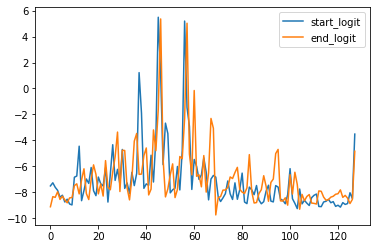

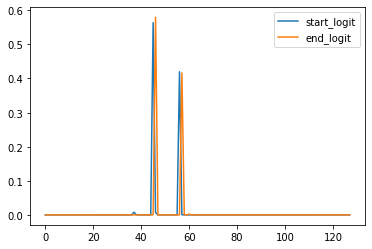

45 46


In [63]:
import matplotlib.pyplot as plt
import numpy as np

def softmax(a):
    exp_a = np.exp(a)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    return y

start_logit = all_results[6].start_logits
end_logit = all_results[6].end_logits
index = np.arange(len(start_logit))

# berore softmax
plt.plot(index, start_logit, label='start_logit')
plt.plot(index, end_logit, label='end_logit')
plt.legend(loc='best')
plt.show()

# after softmax
plt.plot(index, softmax(start_logit), label='start_logit')
plt.plot(index, softmax(end_logit), label='end_logit')
plt.legend(loc='best')
plt.show()

pred_start_index = np.argmax(start_logit)
pred_end_index = np.argmax(end_logit)
print(np.argmax(start_logit), np.argmax(end_logit))

In [87]:
pred_start_index = np.argmax(start_logit)
pred_end_index = np.argmax(end_logit)
orig_doc_start = eval_features[6].token_to_orig_map[pred_start_index]
orig_doc_end = eval_features[6].token_to_orig_map[pred_end_index]
orig_tokens = eval_examples[eval_features[6].example_index].doc_tokens[orig_doc_start:(orig_doc_end + 1)]

print(eval_examples[eval_features[6].example_index])
print("\n\nAnswer: {}".format(" ".join(orig_tokens)))

qas_id: 56be4db0acb8001400a502ef

, question_text: Which NFL team won Super Bowl 50?

, orig_answer_text: None

, doc_tokens: [Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.]


Answer: Denver Broncos


In [69]:
output_dir='./save/predictions'
n_best_size=20
max_answer_length=30
do_lower_case=True
verbose_logging=False

output_prediction_file = os.path.join(output_dir, "squad_test_predictions.json")
output_nbest_file = os.path.join(output_dir, "nbest_squad_test_predictions.json")
all_predictions = write_predictions(eval_examples, eval_features, all_results,
                  n_best_size, max_answer_length,
                  do_lower_case, output_prediction_file,
                  output_nbest_file, verbose_logging)

08/10/2020 05:53:51 - INFO - __main__ -   Writing predictions to: ./save/predictions/squad_test_predictions.json
08/10/2020 05:53:51 - INFO - __main__ -   Writing nbest to: ./save/predictions/nbest_squad_test_predictions.json


## Get scores

In [89]:
with open('./datasets/squad_v1.1/dev-v1.1.json') as f:
    dataset_json = json.load(f)
    dataset = dataset_json['data']
with open('./save/predictions/squad_test_predictions.json') as f:
    preds = json.load(f)

In [90]:
qid_to_has_ans = make_qid_to_has_ans(dataset)  # maps qid to True/False
has_ans_qids = [k for k, v in qid_to_has_ans.items() if v]
no_ans_qids = [k for k, v in qid_to_has_ans.items() if not v]
exact, f1 = get_raw_scores(dataset, preds)

out_eval = make_eval_dict(exact, f1)
out_eval

OrderedDict([('exact', 77.18070009460737),
             ('f1', 84.71442688086603),
             ('total', 10570)])